# Summary of the SuSiE method
The SuSiE method is designed to identify potentially causal variants affecting a trait. It operates under the assumption that the observed phenotypic trait can be modeled as a sum of independent effects from individual genetic variants plus an error term. Mathematically, the model can be expressed as $Y = X\beta + \epsilon$ where Y represents the phenotype vector, X is the genotype matrix, $\beta$ is a sparse vector of effect sizes with most elements being zero (reflecting the sparsity assumption that most SNPs are not causal), and $\epsilon$ is the residual error, which assumed to be normally distributed. SuSiE uses a sparse linear mixed model framework to estimate the posterior probabilities of inclusion (PIPs) for each SNP, providing credible sets of SNPs that likely contain the causal variants with high probability. 

# Overview

This fine-mapping tutorial was developed using simulated data shipped with [`susieR`](https://github.com/stephenslab/susieR) package.
The simulated data contains simulated phenotype matrix $Y$ in $N \approx 600$ individuals. 
The goal is to identify from the genotype matrix $X_{N\times P}$ ($P=1000$) the genetic variables that directly cause changes in the phenotypic values.

**There are several questions throughout the notebook, and please answer each of them by adding cells (in Markdown or R) under the question and keep the code you use there as well.**

The simulated data-set is [available
here](https://github.com/stephenslab/susieR/blob/master/data/N3finemapping.RData),
as part of the `susieR` package. In this tutorial we will first explore the data with conventional univariate association analysis,
then perform preliminary fine-mapping analysis under simplified 
assumptions to illustrate the idea of statistical fine-mapping, and finally use the R package `susieR` to perform formal Bayesian fine-mapping analysis.
We will also discuss fine-mapping using association summary statistics.

# Explore the association data-set

First let's install the package `susieR` according to [its Github repo](https://github.com/stephenslab/susieR) and `corrplot` to draw some plots later. This may take a while.

In [1]:
install.packages("susieR")
install.packages("corrplot")


The downloaded binary packages are in
	/var/folders/02/mmk37p5131l9cfbpk5l93z9r0000gn/T//RtmpNVznvs/downloaded_packages

The downloaded binary packages are in
	/var/folders/02/mmk37p5131l9cfbpk5l93z9r0000gn/T//RtmpNVznvs/downloaded_packages


Please execute the following code cell to load the simulated data.

In [2]:
rm(list=ls())
library(susieR)
library(corrplot)
data(N3finemapping)
attach(N3finemapping)

corrplot 0.92 loaded



In [3]:
ls()

[1] "N3finemapping"

The loaded dataset, `N3finemapping`, contains regression data $X$ and $Y$, 
along with some other relevant attributes in the context of genetic studies. It also
contains the "true" regression coefficients the data is simulated from.

In [4]:
names(N3finemapping)

[1] "X"                 "chrom"             "pos"              
[4] "true_coef"         "residual_variance" "Y"                
[7] "allele_freq"       "V"

In [5]:
dim(X)
head(X)

[1]  574 1001

-0.02090592,0.4738676,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,-0.2421603,0.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,0.006059281,1.1689895,-0.2421603,1.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,-0.026472457,1.1689895,-0.2421603,1.1585366,-0.1567944,...,0.5993031,-0.09254036,0.5880654,-0.2857143,-0.3885017,-0.3919861,0.6030205,-0.02090592,-0.2844549,-0.3883308
-0.02090592,0.4738676,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,-0.2421603,0.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,1.1620209,-0.05226481,-0.1637631,-0.026472457,1.1689895,-0.2421603,1.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308
-0.02090592,-0.5261324,0.1620209,-0.05226481,-0.1637631,-0.026472457,0.1689895,0.7578397,0.1585366,-0.1567944,...,-0.4006969,-1.09254036,-0.4119346,-0.2857143,-0.3885017,-0.3919861,-0.3969795,-0.02090592,-0.2844549,-0.3883308


-----------------------------------------

**Example question: in the genotype matrix `X`, how many individuals and the genetic variants are included? What is the genotype value for the 100th variant of the 21st individual?**

**Example answer:** The genotype matrix has 574 individuals and 1001 genetic variants. The genotype value for the 100th variant of the 21st individual is 0.4408.

In [6]:
dim(X)

[1]  574 1001

In [7]:
X[21, 100]

[1] 0.4407666

-----------------------------------------

The phenotype matrix contains values for the 574 individuals for 2 traits,

In [6]:
dim(Y)

[1] 574   2

We focus on the first trait, let

In [7]:
y = Y[,1]
b = true_coef[,1]

There are 3 "causal" variants for this trait,

In [8]:
which(b != 0)

[1] 403 653 773

Note: in this tutorial we will avoid the phrase "causal", and use "effect variable" to refer to the variants having true non-zero effects on the phenotype.

-----------------------------------------

**Question 1: Please use R function `plot` to visualize the true effects vector. What are the effect sizes for these 3 "causal" variants?**

**Answer: For variant 403, effect size is 1.19. For varient 653, effect size is -0.83. For varient 773, effect size is 1.4.**

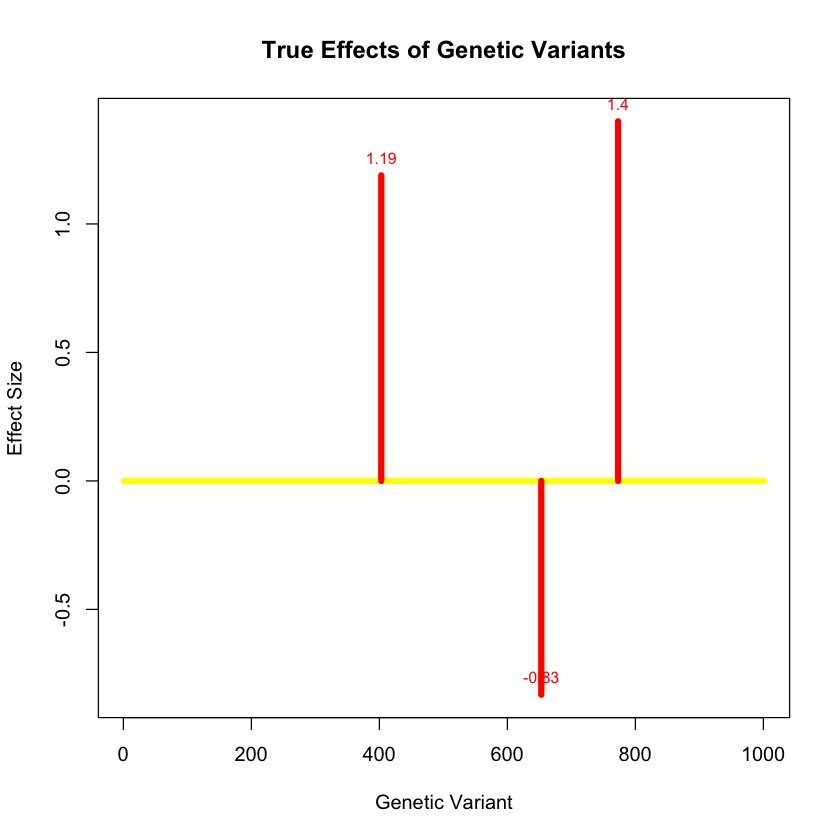

In [13]:
variants <- 1:length(b)
plot(variants, b, type = "h",
     lwd = 5,
     col = "yellow",
     xlab = "Genetic Variant",
     ylab = "Effect Size",
     main = "True Effects of Genetic Variants")
causal_variants <- c(403, 653, 773)
points(causal_variants, b[causal_variants], type = "h", col = "red", lwd = 5)
text(causal_variants, b[causal_variants], labels = round(b[causal_variants], 2), pos = 3, cex = 0.8, col = "red")

-----------------------------------------

# Association testing via simple linear regression

`univariate_regression` function in `susieR` can be used to perform association testing 
by fitting univariate simple regression for each variable separately.
The results are $\hat{\beta}$ for effect size estimates, and their standard errors $SE(\hat{\beta})$.

In [14]:
sumstats <- univariate_regression(X, y)

-----------------------------------------

**Question 2: Please use R function plot to compare the true effects variable `b` with the estimated effect sizes `sumstats$betahat`. Are they consistent, and why?**

**Answer: They are consistent. Among all variants, there are only 3 effects varibale. The estimated effect size is close to the true effects for these three variants.**

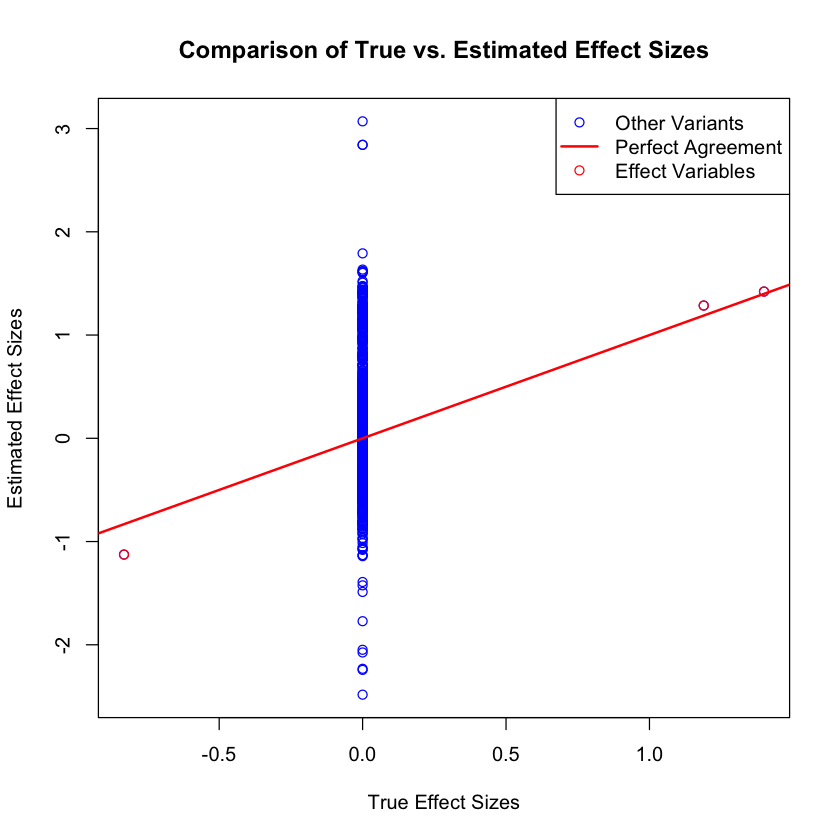

In [30]:
plot(b, sumstats$betahat,
     xlab = "True Effect Sizes",
     ylab = "Estimated Effect Sizes",
     main = "Comparison of True vs. Estimated Effect Sizes",
     col = "blue")
abline(a = 0, b = 1, lwd = 2, col = "red")
causal_variants <- c(403, 653, 773)
points(b[causal_variants], sumstats$betahat[causal_variants], col = "red")

legend("topright",
     legend = c("Other Variants", "Perfect Agreement", "Effect Variables"),
     col = c("blue", "red", "red"),
     pch = c(1, NA, 1),
     lty = c(NA, 1, NA),
     lwd = c(NA, 2, NA))

-----------------------------------------

z-scores can be derived from these quantities; $-log_{10}$ p-values can then becomputed from z-scores, 

In [31]:
z_scores <- sumstats$betahat / sumstats$sebetahat
log10p <- -log10(pchisq(z_scores^2,1,lower.tail=F))

-----------------------------------------

**Question 3: How many variables have p-values smaller than $5 \times 10^{-8}$? How would you interpret those variants based on the univariate association analysis?**


**Answer: 8 variables have p-value smaller than $5 \times 10^{-8}$. The test suggests a strong association between each of theses 8 genetic variants and the trait under study. **

In [33]:
threshold_log10p <- -log10(5e-8)
num_significant <- sum(log10p > threshold_log10p)
num_significant

[1] 8

**Question 4: What's the correlation between these variables (with p-values smaller than $5 \times 10^{-8}$) in the original genotype data `X`? Draw a correlogram and print out the pair with highest positive correlation. What does it mean for those two variants?**

**Answer: See correlations in corr_matrix. The pair with the highest positive correlation is between variants at positions 777 and 773 with a correlation of 0.9815726. It means that these two variants are highly positivel correlated and it's unclear which of them is truly causal.**

In [34]:
significant_indices <- which(log10p > threshold_log10p)
X_significant <- X[, significant_indices]
cor_matrix <- cor(X_significant)
cor_matrix

1.0000000,-0.3511421,-0.3647944,-0.1854644,-0.2429645,-0.1803475,-0.1969529,-0.1418438
-0.3511421,1.0000000,0.9737376,0.3928334,0.2628111,0.3753997,0.3331336,0.4018882
-0.3647944,0.9737376,1.0000000,0.3820795,0.2755016,0.3561769,0.3175036,0.3883458
-0.1854644,0.3928334,0.3820795,1.0000000,0.7218464,0.9815726,0.8092507,0.7241610
-0.2429645,0.2628111,0.2755016,0.7218464,1.0000000,0.7083909,0.5927393,0.5456387
-0.1803475,0.3753997,0.3561769,0.9815726,0.7083909,1.0000000,0.8196254,0.7361508
-0.1969529,0.3331336,0.3175036,0.8092507,0.5927393,0.8196254,1.0000000,0.8474659
-0.1418438,0.4018882,0.3883458,0.7241610,0.5456387,0.7361508,0.8474659,1.0000000


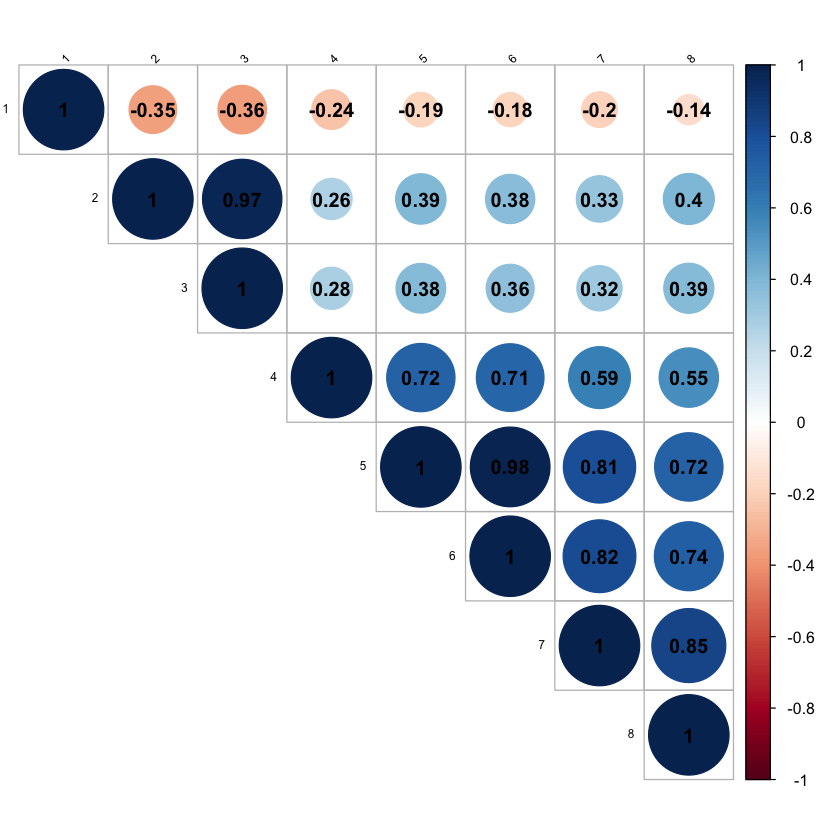

In [35]:
library(corrplot)

corrplot(cor_matrix, method = "circle", type = "upper", order = "hclust",
         tl.col = "black", tl.srt = 45, tl.cex = 0.6, addCoef.col = "black")

In [39]:
diag(cor_matrix) <- 0
which.max.cor <- which(cor_matrix == max(cor_matrix), arr.ind = TRUE)

# Print out the pair with the highest correlation
highest_cor_pair <- significant_indices[which.max.cor]
highest_cor_value <- cor_matrix[which.max.cor]

cat("The pair with the highest positive correlation is between variants at positions",
    highest_cor_pair[1], "and", highest_cor_pair[2],
    "with a correlation of", highest_cor_value[1], "\n")


The pair with the highest positive correlation is between variants at positions 777 and 773 with a correlation of 0.9815726 


-----------------------------------------

`susieR` package provides a plot function to generate Manhattan plot for the association test results. Notice that the true effect variables are labelled in red (true effects provided to `susie_plot` via setting `b=` parameter),

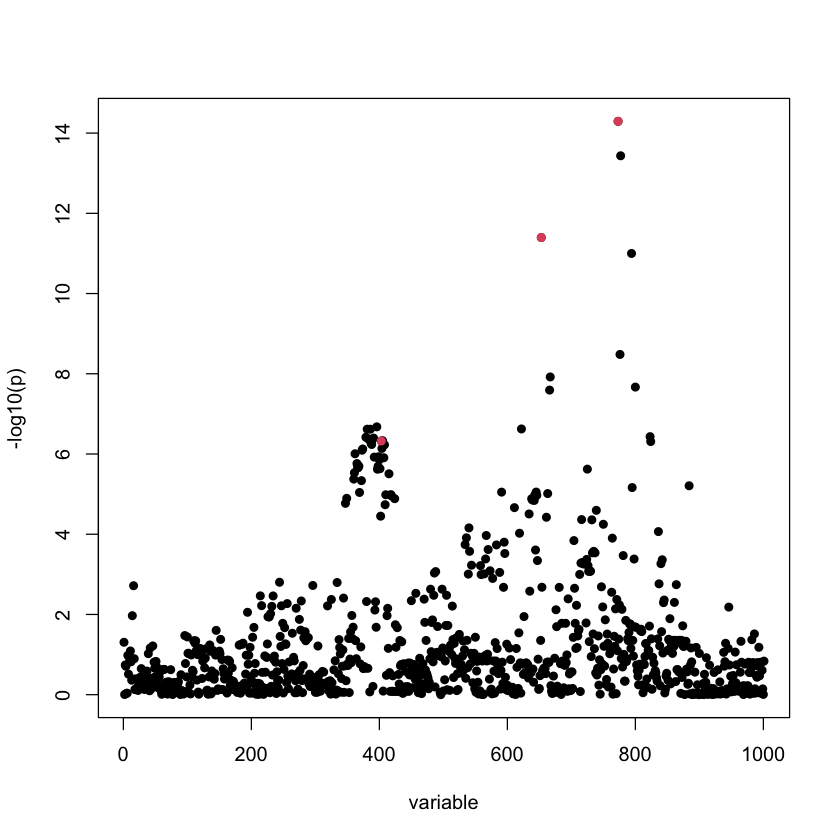

In [59]:
susie_plot(z_scores,y="z",b=b)

As shown on this plot, the "lead" SNP (the one with smallest p-value) is indeed one of the true effect variables. However, the 2nd most significant SNP is not one of the other two effect variables, and there are many other SNPs having p-values smaller than $5 \times 10^{-8}$, a widely accepted significant level threshold for genetic association studies.

-----------------------------------------

**Question 5: What index is the second most significant SNP? Is it one of the other two true effect variables? What would you say about the relationship between the top and 2nd most significant SNPs?**


**Answer: The index is 777. It is not one of the other two true effect variables. The top and 2nd most significant SNPs has correlation 0.9816. They are closely related.**

In [60]:
sorted_indices <- order(log10p, decreasing = TRUE)
most_significant <- sorted_indices[1]
second_most_significant <- sorted_indices[2]
second_most_significant

[1] 777

In [61]:
variant_most_significant <- X[, most_significant]
variant_second_most_significant <- X[, second_most_significant]
correlation <- cor(variant_most_significant, variant_second_most_significant)
print(correlation)

[1] 0.9815726


# "One causal variant" assumption for fine-mapping

Under the assumption that there is only one true effect in the region of interest, fine-mapping does not have to use linkage disequilibrium (LD) information between variables. It can be performed by simply calculating the likelihood of the association model for each variable separately, then computing the probability for a variable being the true effect as the ratio of its likelihood over the sum of likelihoods over all variables. We use linear regression `lm` in R to compute the log-likelihood,

In [62]:
lliks = sapply(1:ncol(X), function(i) logLik(lm(y~X[,i])))

Then compute the probability for each variable being the true effect variable: 

In [63]:
lliks = lliks - max(lliks) # To avoid taking exp on large numbers in the next line, thus improving numerical stability 
probs = exp(lliks)/sum(exp(lliks))

We use `susie_plot` function to plot these probabilities computed, and color label the true effect variables:

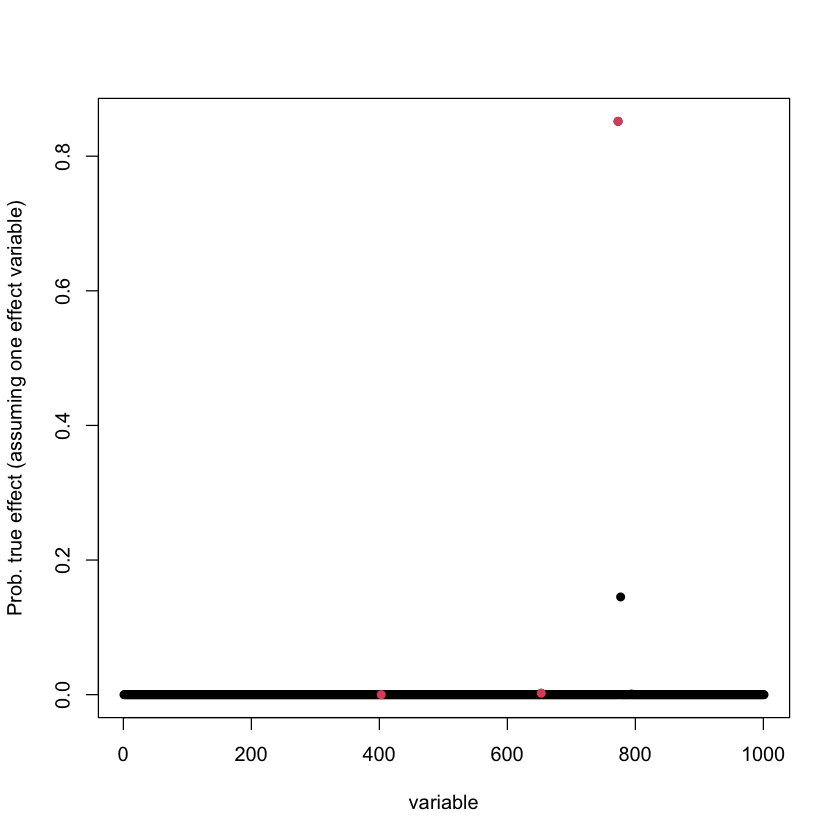

In [64]:
susie_plot(probs, y="PIP", b=b, ylab = "Prob. true effect (assuming one effect variable)")

As expected, under the "one causal variant" assumption, only the lead SNP is identified with over 80% probability of having a non-zero effect. The other two true effect variables in red are not identified.

## 95% credible set for single effect

95% credible set (CS) is defined as a set of variables with 95% probability of containing a true effect. By visually examine the plot above, we can see that the lead SNP has over 80% probability being the true effect, and another SNP near it has almost 20% probability of being the true effect. The 95% credible set should thus contain both of them in order for the coverage to exceed 95%. Indeed, we can formally verify this using an internal function `in_CS` to assess if a variable is in a single effect CS. We report the indices of these variables,

In [65]:
which(susieR:::in_CS(t(probs), coverage = 0.95) != 0)

[1] 773 777

These variables indeed correspond to the two non-zero probability variables on the plot above.

# Fine-mapping with individual level data using Sum of Single Effects model

When multiple true effects are expected, formal statistical fine-mapping via Bayesian Variable Selection
should be performed. We fit a Sum of Single Effects (SuSiE) model implemented in `susieR` package, 
assuming at most 10 causal variables (although SuSiE is robust to the choice of `L`).

In [66]:
fitted <- susie(X, y, L = 10)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



## 95% credible sets for each single effect

By default, `susie` function computes 95% CS each containing one effect variable,

In [67]:
print(fitted$sets)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 362 365 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397 398 399
[20] 400 401 403 404 405 407 408 415


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8686309     0.9640176       0.9720711

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9539811

$requested_coverage
[1] 0.95



The 3 true signals have been captured by the 3 CS reported here. The
3rd CS contains many variables, including the true causal variable
`403`. The minimum absolute correlation is 0.86.

-----------------------------------

**Question 6: Print the credible sets if we use 99% as the coverage. Hint: you may want to check the source code for `susie` function from [here](https://github.com/stephenslab/susieR)**.

**Answer:**

In [92]:
fitted <- susie(X, y, L = 10, coverage = 0.99)
print(fitted$sets)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 360 361 362 365 366 367 368 372 373 374 379 381 383 384 386 387 388 389 391
[20] 392 396 397 398 399 400 401 403 404 405 407 408 409 410 415 419


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8310851     0.9499450       0.9556871

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9906629

$requested_coverage
[1] 0.99



**Question 7: does higher coverage mean you have larger CS, or smaller CS? Why is that? Please look at the 3rd CS as an example in the two fitted results, and explain why the minimum absolute correlation is lower when the coverage is higher?**

**Answer: Higher coverage would lead to larger CS as it has to include more variables to make the probability that CS contain true effects higher. Since there are more variables, there are more variability, the minimum correlation becomes lower.**

-----------------------------------

## Posterior inclusion probabilities

Here we summarize the fine-mapping results by posterior inclusion
probability (PIP):

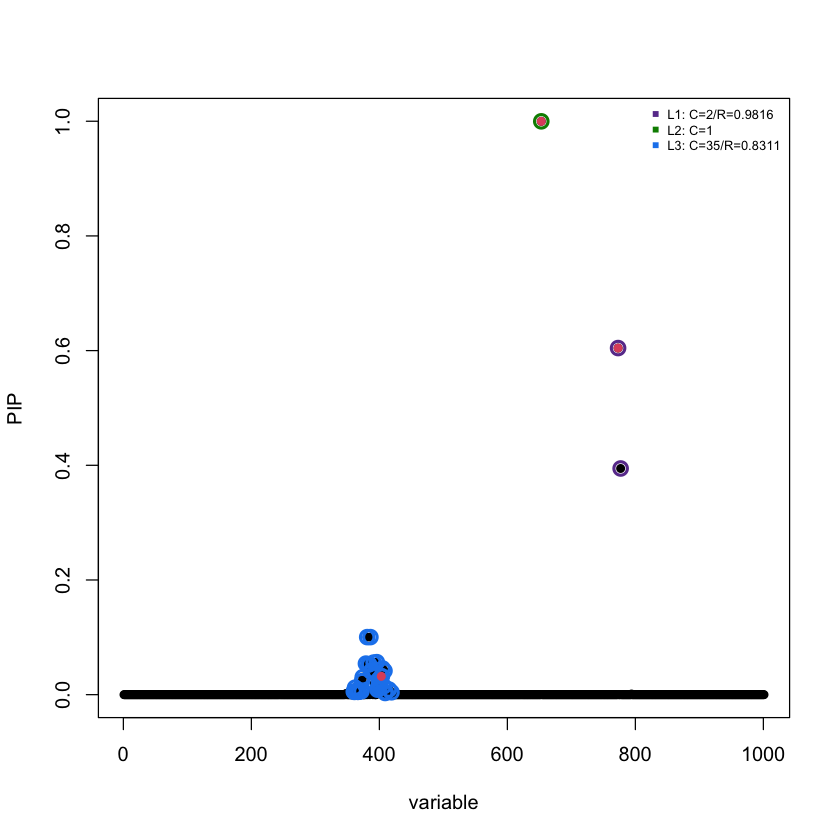

In [93]:
susie_plot(fitted, y="PIP", b=b, add_legend=T)

The true effect variables are colored red, and the three 95% CS identified are
circled in different colors. 

-------------------------------------------

**Question 8: Recall the true effect variables we know before running any susie, and for the variable 403, what is the PIP? What's the average PIP of the 3rd CS? Is the PIP for variable 403 higher or lower than the average, and why is that?**

Hint: You can use the code below to compare $-log_{10}$ p-value and PIP for the CS containing variable 403:

```R
    i  <- fitted$sets$cs$L3
    z3 <- cbind(i,log10p[i],fitted$pip[i])
    colnames(z3) <- c('position', '-log10 pvalue', 'PIP')
    z3[order(z3[,2], decreasing = TRUE),]
```

**Answer: The true effect variables are 403, 653, and 773. The PIP for variable 403 is 0.032. The average PIP of the third CS is 0.035. The PIP for variable 403 is lower than the average, as there are more variables with higher PIP in the 3rd CS.**

In [94]:
i <- fitted$sets$cs$L3
z3 <- cbind(i, log10p[i], fitted$pip[i])
colnames(z3) <- c('position', '-log10 pvalue', 'PIP')
z3[order(z3[,2], decreasing = TRUE),]

position,-log10 pvalue,PIP
396,6.676732,0.056704331
381,6.618518,0.100360243
386,6.618518,0.100360243
379,6.417587,0.054179507
391,6.396640,0.055952118
383,6.370810,0.052896918
384,6.370810,0.052896918
389,6.360493,0.042161265
405,6.331181,0.045761975
403,6.322861,0.031992848


In [95]:
positions <- c(362, 365, 372, 373, 374, 379, 381, 383, 384, 386, 387, 388, 389, 391, 392, 396, 397, 398, 399, 400, 401, 403, 404, 405, 407, 408, 415)
positions <- as.character(positions)
row_indices <- which(z3[, "position"] %in% positions)
extracted_rows <- z3[row_indices, ]
average_pip <- mean(as.numeric(extracted_rows[, "PIP"]))
average_pip

[1] 0.03533265

***

**Question 9: Please rerun the `susie` analysis setting `L=1` to detect a maximum of only one effect across the region. How does the result compare to the previous section of "one causal effect" fine-mapping using likelihoods from univariate analysis?**

**Answer: The result is same. For 95% coverage, they both return variants at positon 773 and 777.**

In [96]:
fitted_1 <- susie(X, y, L = 1)
print(fitted_1$sets)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



$cs
$cs$L1
[1] 773 777


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L1    0.9815726     0.9815726       0.9815726

$cs_index
[1] 1

$coverage
[1] 0.9968218

$requested_coverage
[1] 0.95



-------------------------------------------

## Choice of prior effect size

In SuSiE, the prior effect size is parameterized by the percentage of variance explained by a variable, $h_j^2$. 
By default, SuSiE estimates $h_j^2$ and uses it as the prior (an empirical Bayes approach). 
Here we demonstrate fixing the prior effect size to 0.2, i.e., we believe a non-zero effect variable can explain 20% variation in quantitative trait values:

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



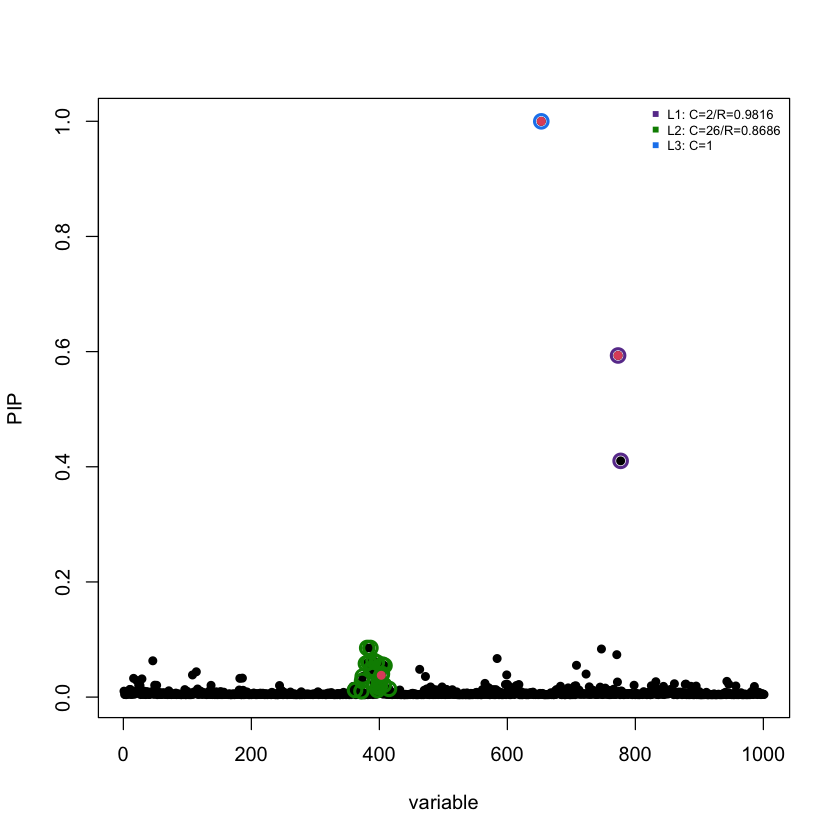

In [85]:
fitted2 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)
susie_plot(fitted2, y='PIP', b=b, add_legend=T)

The result is very similar to when prior effects are estimated. 

-------------------------------------------

**Question 10: Please change `scaled_prior_variance` to different numbers between 0 and 1, and examine the results. What happens if you set it to 0.001, and why?**

**Answer: When I set scaled_prior_variance to 0.6, the result is same. But when I set it to 0.001, variable 777 was selected. I think this is because when the prior is very restrictive, the model might not discriminate well between true effects and noise.**

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



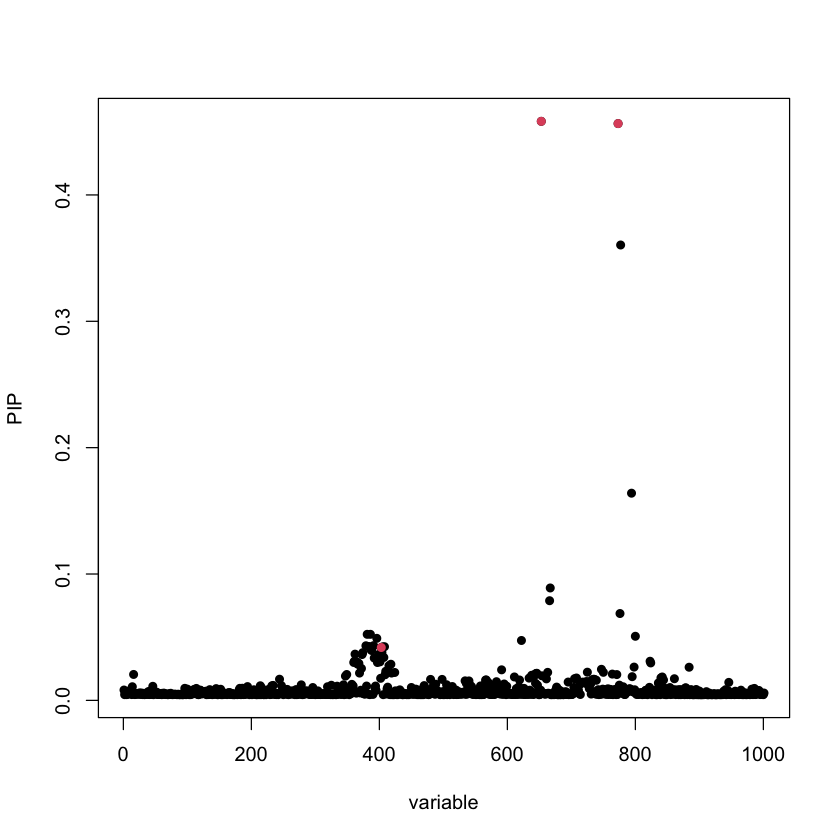

In [88]:
fitted3 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.001)
susie_plot(fitted3, y='PIP', b=b, add_legend=T)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



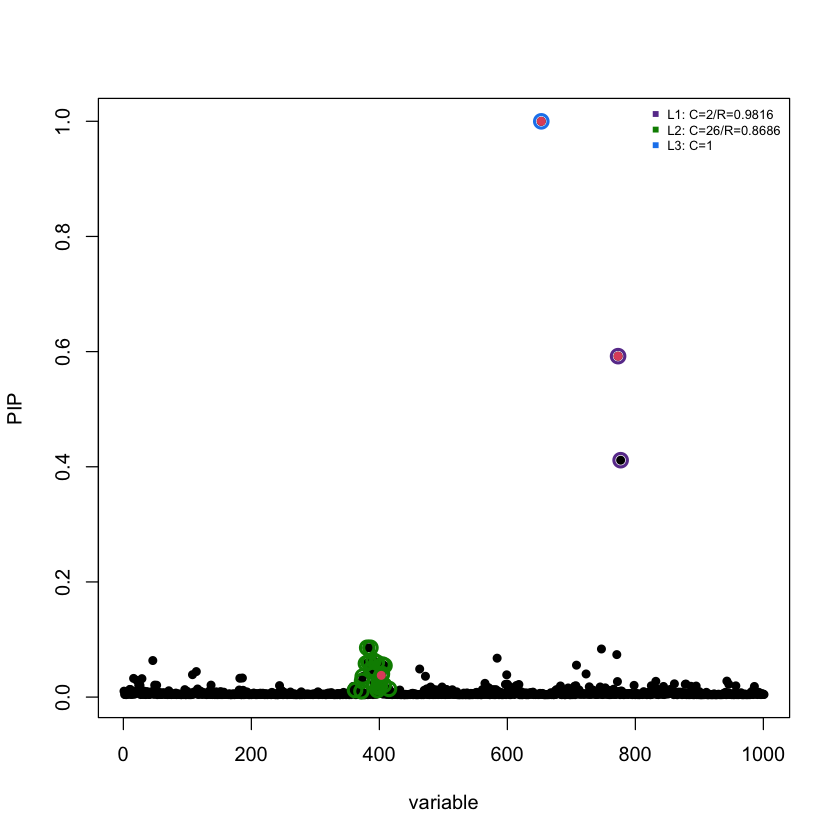

In [87]:
fitted3 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.6)
susie_plot(fitted3, y='PIP', b=b, add_legend=T)

-------------------------------------------

# Fine-mapping with summary statistics via `susie_rss`

Summary statistics of genetic association studies typically contain effect size ($\hat{\beta}$ coefficient from regression), p-value and minor allele frequencies. 
These information can be used to perform fine-mapping with given an additional input of correlation matrix between variables.
The correlation matrix in genetics is typically referred to as LD matrix (LD for linkage disequilibrium). 
One may use external reference panels to estimate it when this matrix cannot be obtained from samples directly. There is a potential problem using LD from reference panel, and we demonstrated it in the next section.
Caution that LD matrix here has to be correlation matrix $r$, not $r^2$ or $|r|$.

We have previously computed z-scores for this data-set. The correlation matrix can be computed directly from $X$ matrix, 

In [89]:
R <- cor(X)

SuSiE regression with summary statistics is implemented as `susie_rss` function, 

In [90]:
fitted_rss <- susie_rss(z_scores, R, L = 10)


HINT: For large R or large XtX, consider installing the Rfast package for better performance.



We compare the PIP obtained with previous analysis using individual level data,

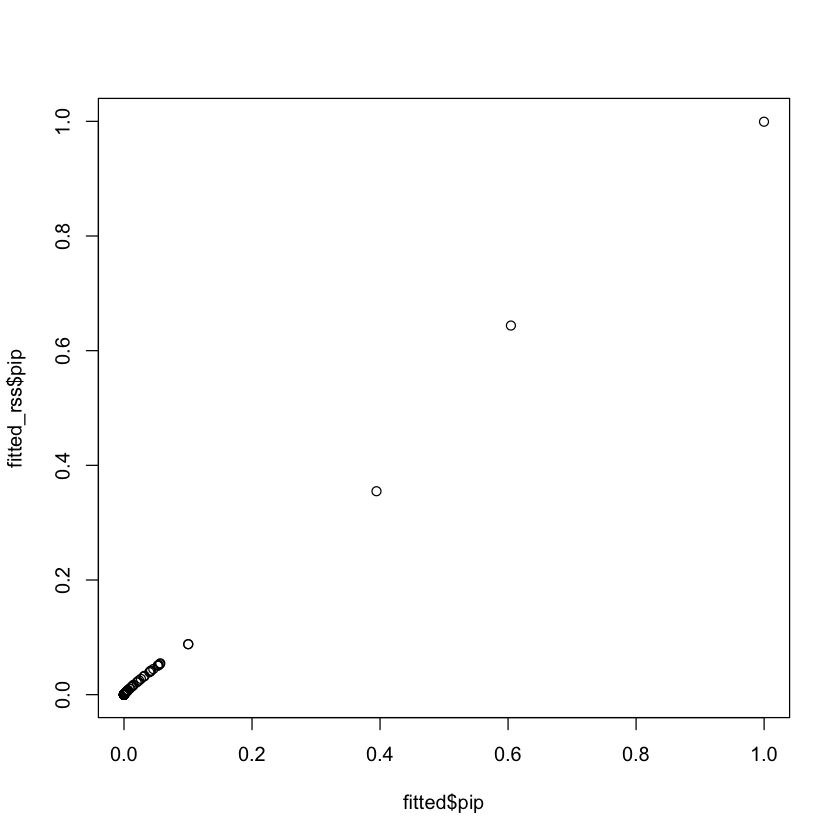

In [97]:
plot(fitted$pip, fitted_rss$pip, ylim=c(0,1))

The results very much agree. This is expected when the summary statistics are indeed derived from the individual level data.

## Use LD from external reference data

When original genotype information is not available, 
one may use reference panel to estimate LD matrix. 
False discoveries may occur if the LD pattern from the reference panel does not agree well with the original sample. 

To illustrate, we randomly generated 500 samples from $N(0,R)$ and treated them as reference panel genotype matrix `X_ref`.

In [98]:
set.seed(1234)
tmp = matrix(rnorm(500*1001), 500, 1001)
eigenR = eigen(R)
eigenR$values[eigenR$values < 1e-10] = 0
X_ref = tmp %*% (eigenR$values * t(eigenR$vectors))
R_ref = cor(X_ref)

Using `susie_rss` function with LD from reference panel,


HINT: For large R or large XtX, consider installing the Rfast package for better performance.



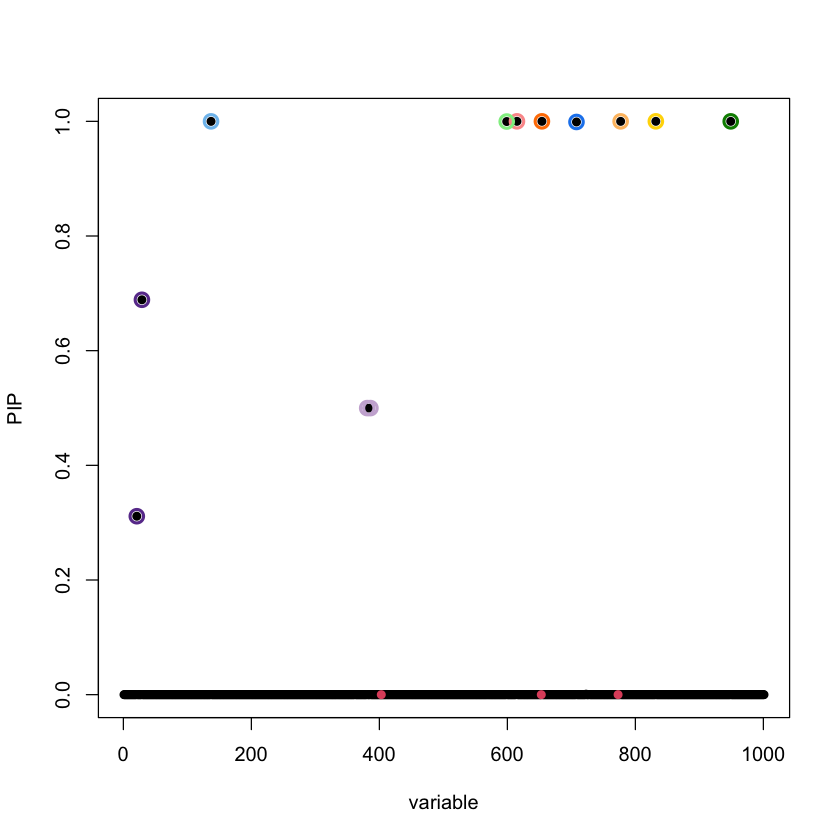

In [99]:
fitted_rss_ref <- susie_rss(z_scores, R_ref, L = 10)
susie_plot(fitted_rss_ref, y="PIP", b=b)

-------------------------------------------

**Question 11: Please compare and comment on the CS reported using reference LD panel versus using the correct LD computed from genotype data. Are there any false discoveries?**

**Answer: Yes, there are false discoveries as the LD pattern from the reference panel does not agree well with the original sample**

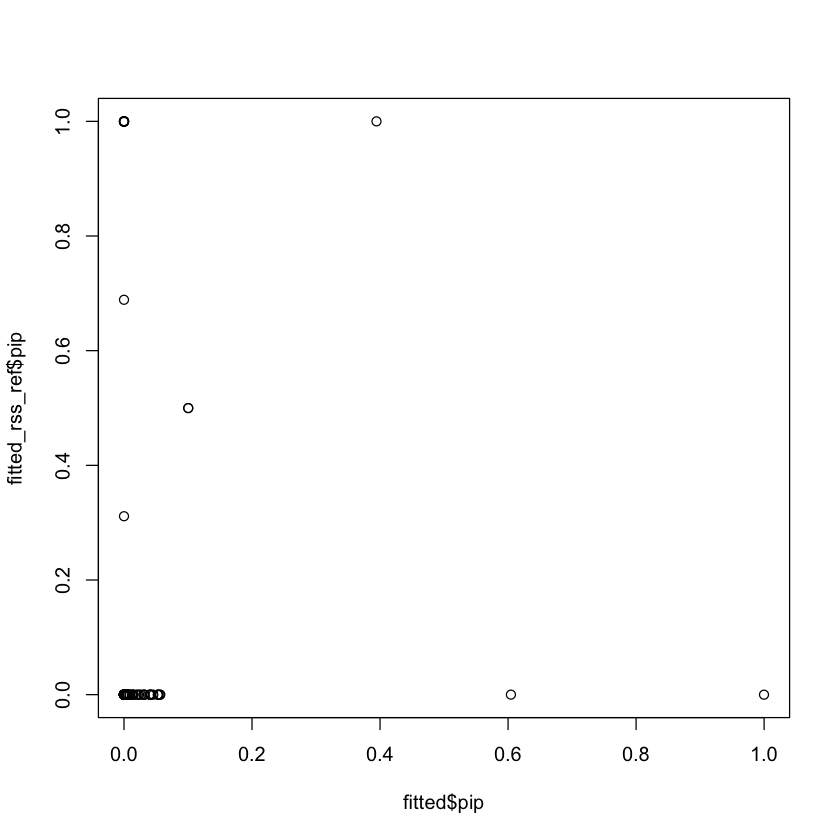

In [100]:
plot(fitted$pip, fitted_rss_ref$pip, ylim=c(0,1))

-------------------------------------------

We recommend the following modification to the LD matrix when reference panel ($R_{ref}$) are used,
$$
\tilde{R} = \text{cov2cor}((1-w)R_{ref}+ w zz^\intercal)),
$$
where z is the original summary statistics. We suggest using $w = 1/n_{ref}$, $n_{ref}$ is the sample size from the reference panel. The modified LD matrix becomes
$$
\tilde{R} = \text{cov2cor}(\frac{n_{ref}-1}{n_{ref}}R_{ref}+ \frac{1}{n_{ref}} zz^\intercal)) = \text{cov2cor}(\frac{1}{n_{ref}}(X_{ref}^\intercal X_{ref}+ zz^\intercal)),
$$
where `X_ref` is column-standardized. This modification is implemented in `susie_rss` with parameter `z_ld_weight`:



HINT: For large R or large XtX, consider installing the Rfast package for better performance.



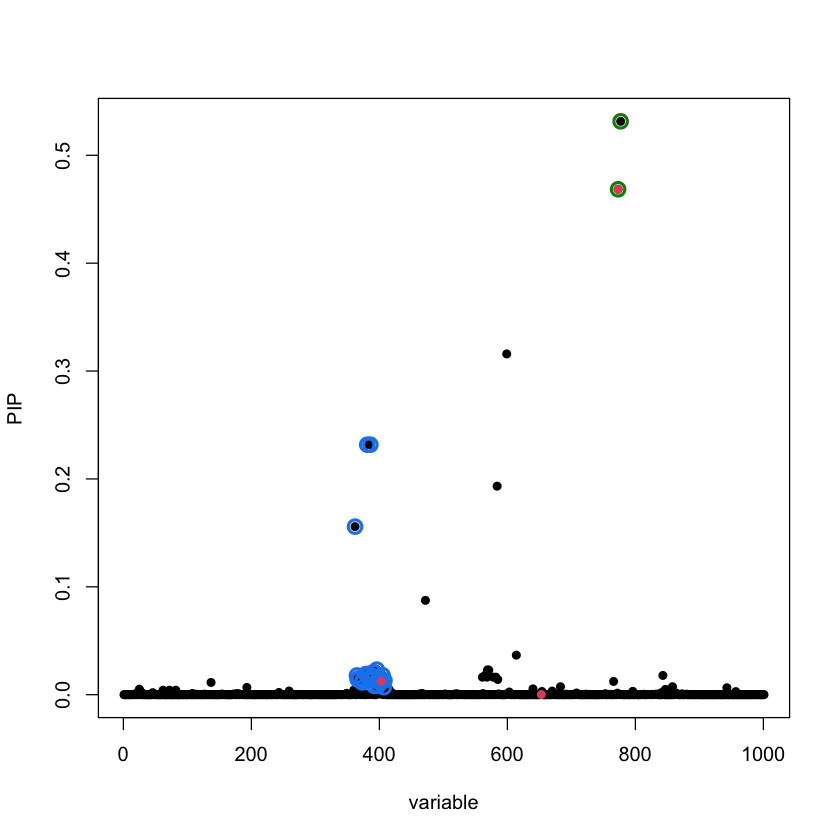

In [101]:
n_ref = 500
fitted_rss_ref_corrected <- susie_rss(z_scores, R_ref, z_ld_weight = 1/n_ref, L = 10)
susie_plot(fitted_rss_ref_corrected, y="PIP", b=b)

***
**Question 12: Please compare and comment on the results using adjusted reference LD panel. Is the result improved?**

**Answer: Results using adjusted reference LD panel is closer to the pip obtained using individual level data. The result is thus improved.**

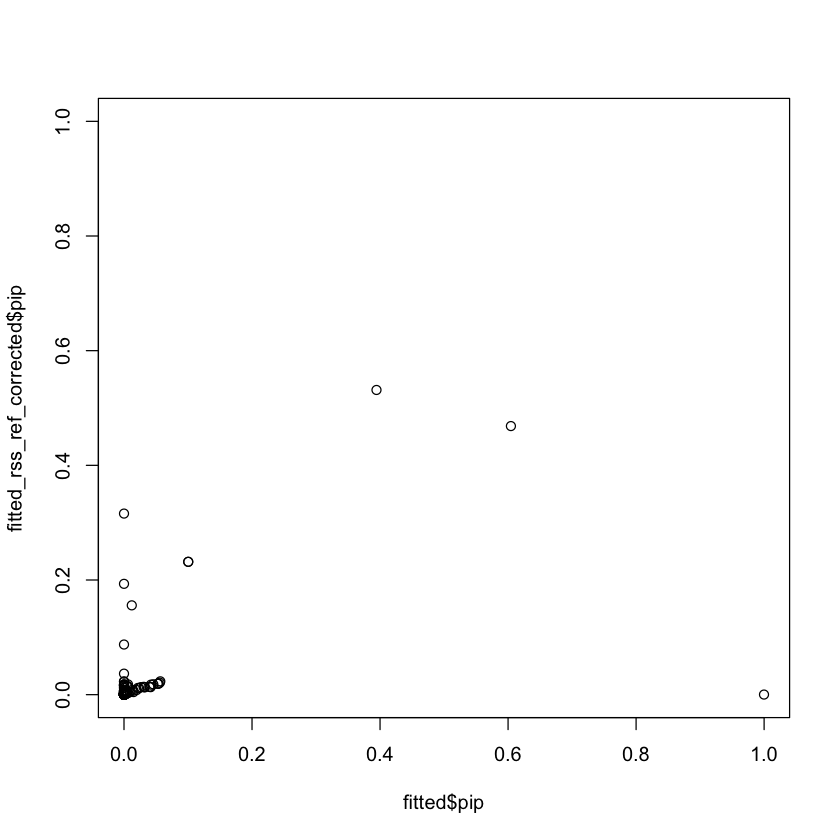

In [102]:
plot(fitted$pip, fitted_rss_ref_corrected$pip, ylim=c(0,1))

***

# Exercise: fine-mapping analysis on a different data-set

Please load and analyze another data-set provided in `susieR` package:

In [103]:
rm(list=ls())
library(susieR)
data(N2finemapping)

Please use the same R code for `N3finemapping` data to analyze this new data-set, similarly focusing on the first column of the phenotype matrix as the phenotype of interest. 
This data-set contains two true effect variables. However, as you are soon to find out in univariate linear regression analysis, **the lead SNP via univariate analysis is neither of the two effect variables**.

-------------------------------------------

**Question 13: please run `susie_rss` on the N2finemapping dataset and report the results below. Does it capture any true effect variant?**

**Answer: After running susie_rss on the N2finemapping dataset, the 2 variants captured are 337 and 935. 337 is the true effect variant but 935 is not.**

In [116]:
X_n2 <- N2finemapping$X
Y_n2 <- N2finemapping$Y

[1] 574   2

In [113]:
y_n2 = Y_n2[,1]
b_n2 = N2finemapping$true_coef[,1]
which(b_n2 != 0)

[1] 337 999

In [117]:
sumstats <- univariate_regression(X_n2, y_n2)
z_scores <- sumstats$betahat / sumstats$sebetahat
fitted_rss_n2 <- susie_rss(z_scores, cor(X_n2), L = 10)


HINT: For large R or large XtX, consider installing the Rfast package for better performance.



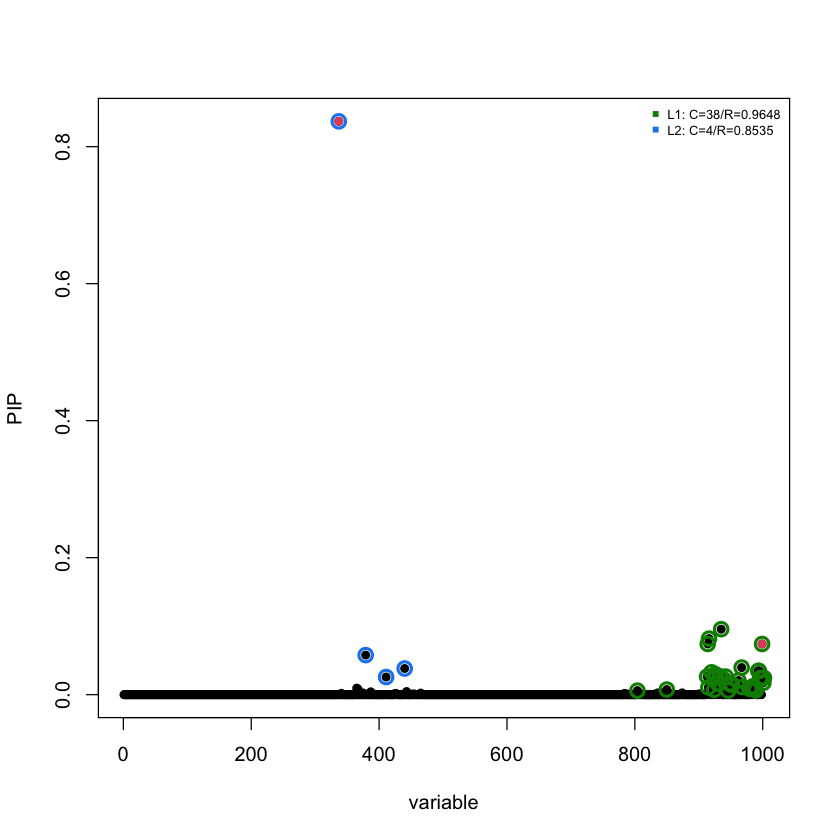

In [118]:
susie_plot(fitted_rss_n2, y='PIP', b=b, add_legend=T)

In [124]:
sorted_indices <- order(fitted_rss_n2$pip, decreasing = TRUE)
largest_positions <- sorted_indices[1:2]
print(largest_positions)

[1] 337 935


-------------------------------------------

In [125]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-apple-darwin20 (64-bit)
Running under: macOS Big Sur 11.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-x86_64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] corrplot_0.92  susieR_0.12.35

loaded via a namespace (and not attached):
 [1] Matrix_1.6-1      gtable_0.3.4      jsonlite_1.8.7    dplyr_1.1.3      
 [5] compiler_4.3.1    crayon_1.5.2      tidyselect_1.2.0  Rcpp_1.0.11      
 [9] IRdisplay_1.1     scales_1.2.1      uuid_1.1-1        fastmap_1.1.1    
[13] IRkernel_1.3.2    lattice_0.21-8    ggplot2_3.4.4     R6_2.5.1         
[17] plyr_1.8.9        generics_0.1.3    mixsqp_0.3-54     tibble_3.2.1     
[21] mu